
 # HHM - Referente

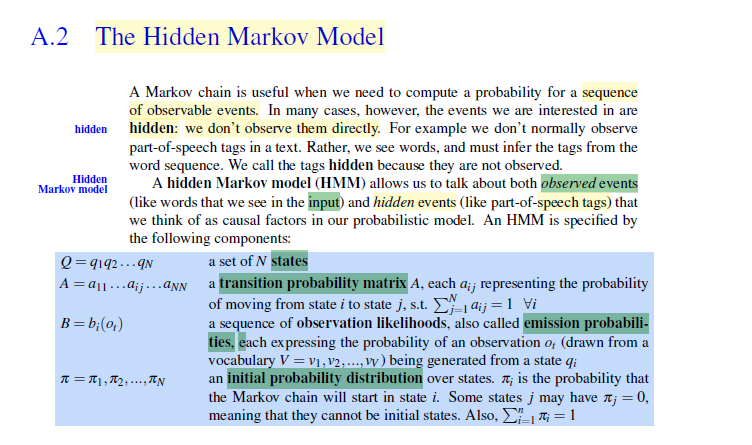

## Cargando librerias de trabajo

In [1]:
#!pip install pyclustering




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.io as pio
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric

In [2]:
# Ruta absoluta al archivo CSV
csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_var_obs.csv")

# Leer el CSV directamente
df_XDB = pd.read_csv(csv_path, encoding="utf-8-sig")

# Mostrar primeras filas
df_XDB.head()


,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm)
0,False,True,0.000000,0.000000,0.4,1.000000,0.50,0.2,0.320534,0.966102
1,False,False,1.000000,0.222222,0.6,0.666667,1.00,0.6,0.612688,0.898305
2,False,False,1.000000,0.555556,1.0,0.111111,0.50,0.0,0.220367,0.322034
3,False,False,0.333333,1.000000,0.2,0.555556,0.50,0.2,0.602671,0.152542
4,False,False,0.222222,0.333333,0.6,0.666667,0.75,0.4,0.886477,0.084746


## Creacion de la columna tiempo y el ID

In [3]:

# Define cuántos pasos quieres por sujeto (mínimo 2)
T = 2
n = len(df_XDB)
n_ids = max(1, n // T)

# Asigna IDs ciclando (1,1,1,2,2,2,3,3,3,...) y baraja si quieres
ids = np.repeat(np.arange(1, n_ids+1), T)[:n]
np.random.seed(42)
np.random.shuffle(ids)

df_XDB_ID = df_XDB.copy()
df_XDB_ID['ID'] = ids

# Crea una fecha simulada por ID con saltos aleatorios (tu estrategia 2)
df_XDB_ID = df_XDB_ID.sort_values('ID').reset_index(drop=True)
df_XDB_ID['fecha'] = (
    pd.to_datetime("2022-01-01") 
    + pd.to_timedelta(
        df_XDB_ID.groupby('ID').cumcount().values * 30  # ~mensual
        + np.random.randint(0, 15, size=len(df_XDB_ID)), # irregularidad
        unit='D'
    )
)

# Orden final y 'time'
df_XDB_ID = df_XDB_ID.sort_values(['ID','fecha']).reset_index(drop=True)
df_XDB_ID['time'] = df_XDB_ID.groupby('ID').cumcount() + 1

In [4]:
df_XDB_ID.head(10)

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1
5,True,False,0.555556,0.555556,0.6,0.333333,0.75,0.2,0.420701,0.694915,3,2022-02-09,2
6,False,False,0.555556,0.333333,0.8,0.333333,0.75,0.8,0.026711,0.847458,4,2022-01-14,1
7,True,False,0.000000,0.333333,0.0,0.000000,0.75,1.0,0.330551,0.677966,4,2022-02-10,2
8,False,False,0.000000,0.111111,0.2,0.333333,0.50,0.2,0.824708,0.542373,5,2022-01-15,1
9,True,False,0.111111,0.333333,0.2,0.111111,0.00,0.4,0.871452,0.016949,5,2022-02-10,2


## Procesamiento de datos

In [5]:
# Orden temporal por ID y fecha (si tienes múltiples individuos/series)
# Ajusta el parseo de 'fecha' según formato si es necesario:
df_XDB_ID["fecha"] = pd.to_datetime(df_XDB_ID["fecha"], errors="coerce")
df_XDB_ID = df_XDB_ID.sort_values(["ID", "fecha", "time"], na_position="last").reset_index(drop=True)




# VARIABLE NO OBSERVABLE (Y_d)
# ------------------------------
# Tomamos Anxiety Level como *proxy* de la variable latente y la convertimos a [0,1]
y_cont = df_XDB_ID["Anxiety Level"].astype(float).values.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)   # 0=sano ... 1=peor (ya no invertimos)



In [6]:
df_XDB_ID.head()

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1


In [7]:
display(y_cont)

array([[0.4],
       [0.4],
       [1. ],
       ...,
       [0.6],
       [1. ],
       [0.8]], shape=(22000, 1))

## Modelación - Variable observable

Se procede con la construcción de la matriz de transición del riesgo para la variable no observable - Anxiety Level

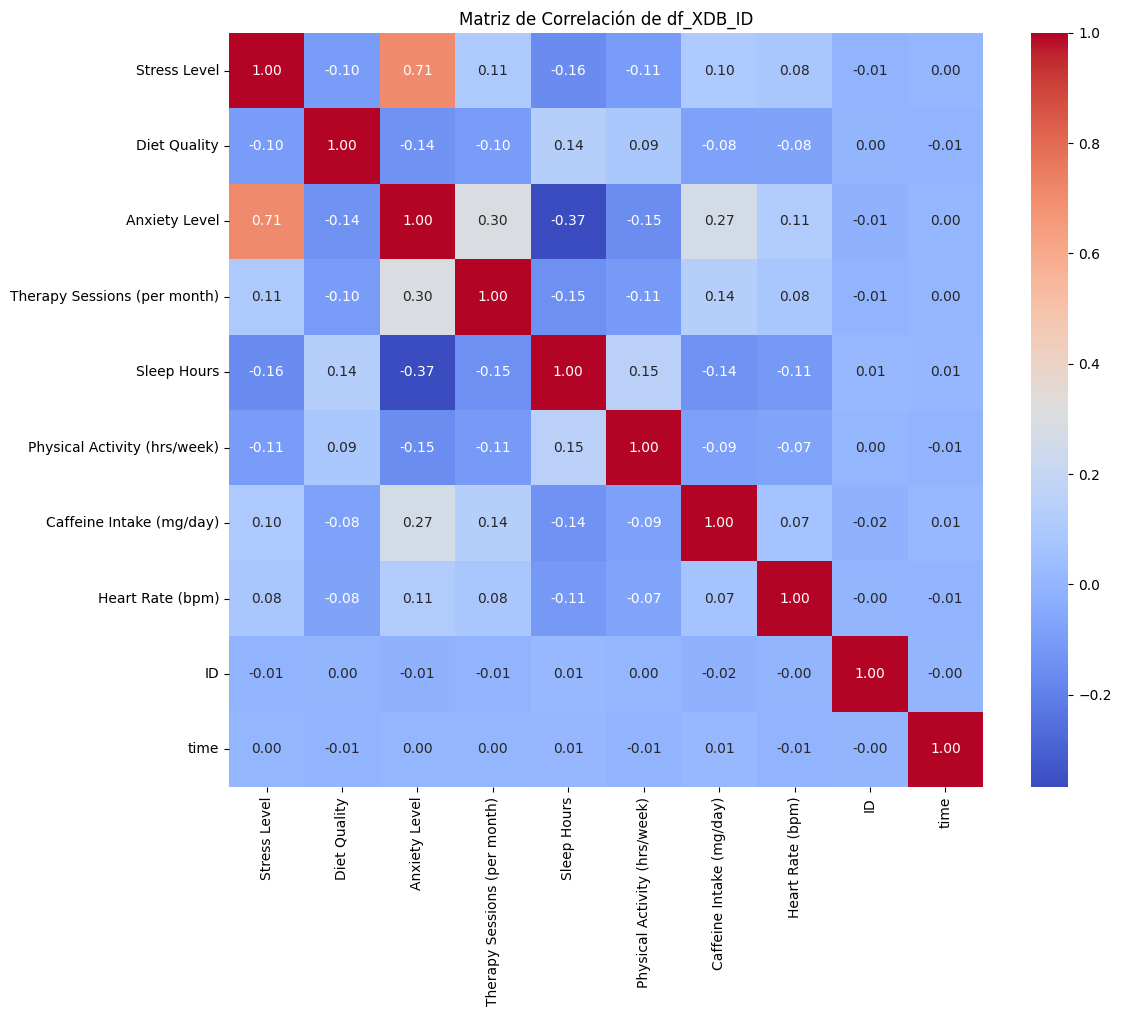

In [8]:

# Selecciona solo las columnas numéricas para la matriz de correlación
corr = df_XDB_ID.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación de df_XDB_ID")
plt.tight_layout()
plt.show()

In [9]:
cols = [
    'Smoking', 'Stress Level',
    'Therapy Sessions (per month)', 'Sleep Hours', 'Anxiety Level',
    'Physical Activity (hrs/week)'
]

# Filtra solo las columnas que existen en df_XDB_ID
cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_selected  = df_XDB_ID[cols_exist].copy()

df_selected.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week)
0,False,0.888889,0.000000,0.25,0.4,0.6
1,False,0.111111,0.444444,0.50,0.4,0.8
2,True,1.000000,1.000000,0.00,1.0,0.0
3,False,0.666667,0.888889,0.25,1.0,0.0
4,False,1.000000,0.888889,1.00,1.0,0.6


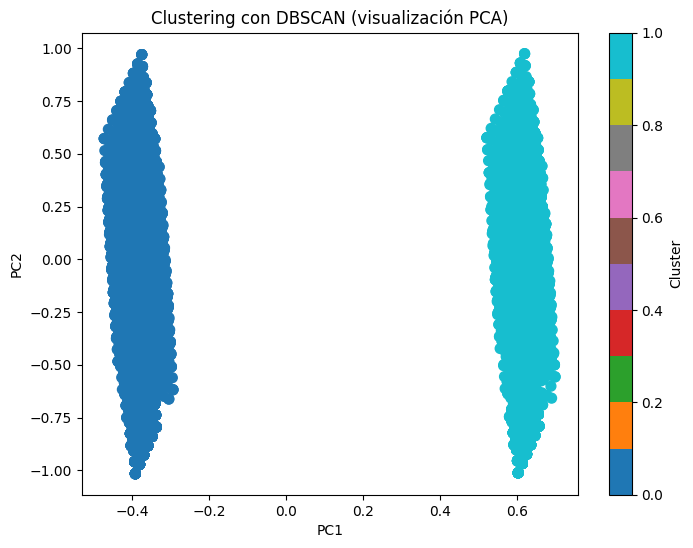

Cluster_DBSCAN
0    13732
1     8268
Name: count, dtype: int64


In [11]:

# Clustering con DBSCAN

# 2. Definir variables observables (excluimos la no observable: Anxiety Level)
observables = df_selected.drop(columns=["Anxiety Level"])

# 3. Aplicar DBSCAN (ajusta eps y min_samples según resultados)
dbscan = DBSCAN(eps=0.8, min_samples=10)  
clusters = dbscan.fit_predict(observables)

# Guardar resultado en el dataframe
df_selected["Cluster_DBSCAN"] = clusters

# 5. Visualización con PCA a 2D
pca = PCA(n_components=4)
X_pca = pca.fit_transform(observables)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=50)
plt.title("Clustering con DBSCAN (visualización PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Ver distribución de clusters
print(df_selected["Cluster_DBSCAN"].value_counts())


In [12]:
# --- Plotly 3D para DBSCAN en espacio PCA ---

# )

# 2) PCA a 3D
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(observables)
evr = pca3.explained_variance_ratio_

# 3) DataFrame para plotly
df_plot = pd.DataFrame({
    "PC1": X_pca3[:, 0],
    "PC2": X_pca3[:, 1],
    "PC3": X_pca3[:, 2],
    "Cluster": clusters  # viene de tu DBSCAN
}, index=df_selected.index)

# 4) Colores: ruido (-1) en gris, clusters en paleta cualitativa
uniq = sorted(df_plot["Cluster"].unique())
palette = (
    px.colors.qualitative.T10
    + px.colors.qualitative.Set3
    + px.colors.qualitative.Safe
    + px.colors.qualitative.Plotly
)
color_discrete_map = {}
pi = 0
for u in uniq:
    if u == -1:
        color_discrete_map[u] = "gray"
    else:
        color_discrete_map[u] = palette[pi % len(palette)]
        pi += 1

# 5) Scatter 3D interactivo
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="Cluster",
    color_discrete_map=color_discrete_map,
    opacity=0.9,
    hover_data={
        "Cluster": True,
        "PC1": ':.3f',
        "PC2": ':.3f',
        "PC3": ':.3f'
    },
    title=(
        "DBSCAN en PCA 3D — Varianza explicada: "
        f"{evr[0]*100:.1f}%, {evr[1]*100:.1f}%, {evr[2]*100:.1f}%"
    )
)

fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color="black")))
fig.update_layout(
    legend_title_text="Etiqueta DBSCAN",
    scene=dict(
        xaxis_title=f"PC1 ({evr[0]*100:.1f}%)",
        yaxis_title=f"PC2 ({evr[1]*100:.1f}%)",
        zaxis_title=f"PC3 ({evr[2]*100:.1f}%)"
    )
)

fig.show()

# 6) [OPCIONAL] Guardar a HTML interactivo
fig.write_html("dbscan_pca3d.html", include_plotlyjs="cdn")


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

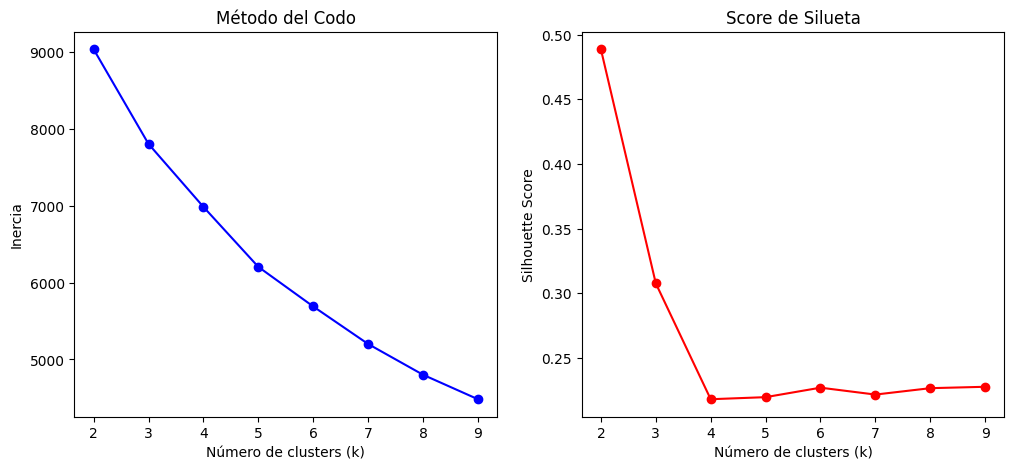

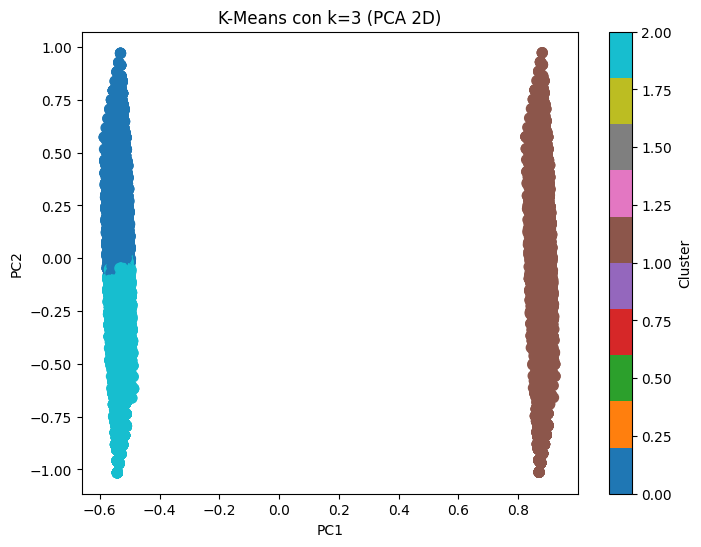

Cluster_KMeans
1    8268
0    7886
2    5846
Name: count, dtype: int64
                Smoking  Stress Level  Therapy Sessions (per month)  \
Cluster_KMeans                                                        
0                   0.0      0.390087                      0.336024   
1                   1.0      0.542547                      0.355386   
2                   0.0      0.727107                      0.530904   

                Sleep Hours  Physical Activity (hrs/week)  Cluster_DBSCAN  
Cluster_KMeans                                                             
0                  0.671728                      0.620365             0.0  
1                  0.516993                      0.455298             1.0  
2                  0.378079                      0.260794             0.0  


In [13]:
### K Means --- Observables

# 1. Cargar dataset
# 2. Seleccionar variables observables
observables = df_selected.drop(columns=["Anxiety Level"])

# 3. Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  # probar entre 2 y 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# 4. Ajustar modelo con el k óptimo (ejemplo k=3)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)

# 5. Visualización con PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(observables)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# 6. Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[observables.columns].mean())


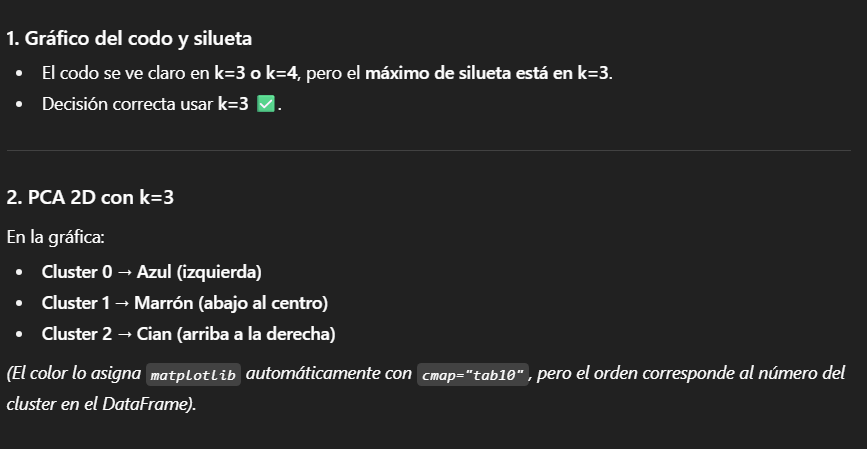

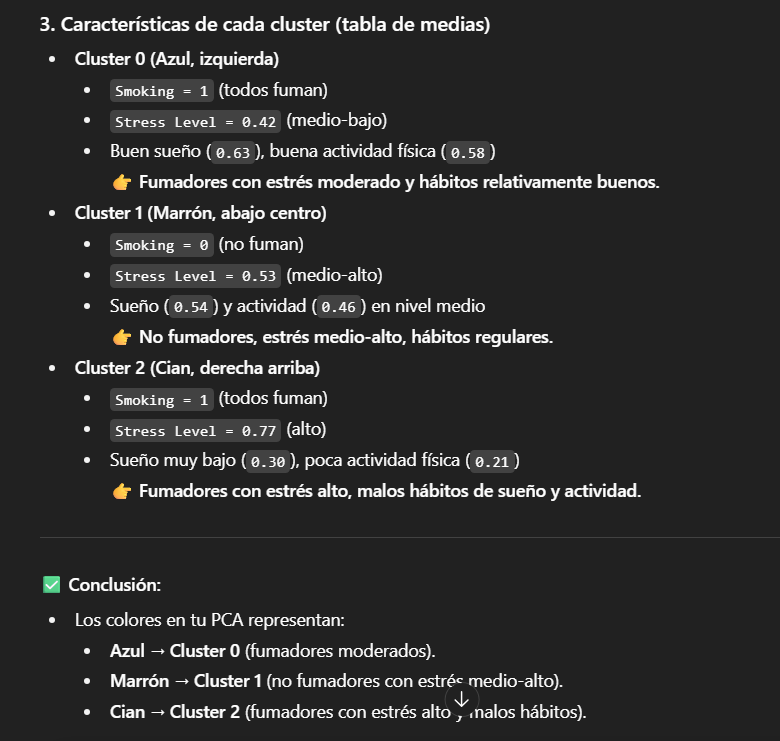

In [14]:


# ==========================
# 1. Configurar renderizador
# ==========================
pio.renderers.default = "browser"   # abrirá el gráfico en tu navegador por defecto

# ==========================
# 2. Cargar dataset

# ==========================
# 3. Variables observables (quitamos Anxiety Level)
# ==========================
observables = df_selected.drop(columns=["Anxiety Level"])

# ==========================
# 4. Ajustar K-Means con k=3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)

# ==========================
# 5. Reducir a 3D con PCA
# ==========================
pca = PCA(n_components=3)
X3 = pca.fit_transform(observables)

df_selected["PC1"] = X3[:,0]
df_selected["PC2"] = X3[:,1]
df_selected["PC3"] = X3[:,2]

# ==========================
# 6. Visualización 3D interactiva con Plotly
# ==========================
fig = px.scatter_3d(
    df_selected, x="PC1", y="PC2", z="PC3",
    color=df_selected["Cluster_KMeans"].astype(str),  # clusters como categorías
    symbol=df_selected["Cluster_KMeans"].astype(str),
    hover_data=["Stress Level", "Sleep Hours", "Physical Activity (hrs/week)", "Smoking"],
    title="Clusters K-Means en 3D (PCA)",
    opacity=0.7
)

fig.show()

# Guardar el gráfico en un archivo HTML
#fig.write_html("clusters_kmeans_3d.html", include_plotlyjs="cdn", auto_open=True)


In [15]:



X = df_selected.drop(columns=["Anxiety Level"]).values

# inicialización: elige índices aleatorios como medoides iniciales
k = 3
np.random.seed(42)
initial_medoids = np.random.choice(len(X), size=k, replace=False).tolist()

# métrica euclídea (puedes cambiar a manhattan si quieres)
metric = distance_metric(type_metric.MANHATTAN)

kmed = kmedoids(X, initial_medoids, metric=metric)
kmed.process()
labels = np.zeros(len(X), dtype=int)
for i, cluster in enumerate(kmed.get_clusters()):
    labels[cluster] = i

df_selected["Cluster_KMedoids"] = labels
print(df_selected["Cluster_KMedoids"].value_counts())
print(df_selected.groupby("Cluster_KMedoids").mean(numeric_only=True))


Cluster_KMedoids
2    8268
0    7886
1    5846
Name: count, dtype: int64
                  Smoking  Stress Level  Therapy Sessions (per month)  \
Cluster_KMedoids                                                        
0                     0.0      0.390087                      0.336024   
1                     0.0      0.727107                      0.530904   
2                     1.0      0.542547                      0.355386   

                  Sleep Hours  Anxiety Level  Physical Activity (hrs/week)  \
Cluster_KMedoids                                                             
0                    0.671728       0.414887                      0.620365   
1                    0.378079       0.726103                      0.260794   
2                    0.516993       0.551669                      0.455298   

                  Cluster_DBSCAN  Cluster_KMeans       PC1       PC2       PC3  
Cluster_KMedoids                                                                
0       

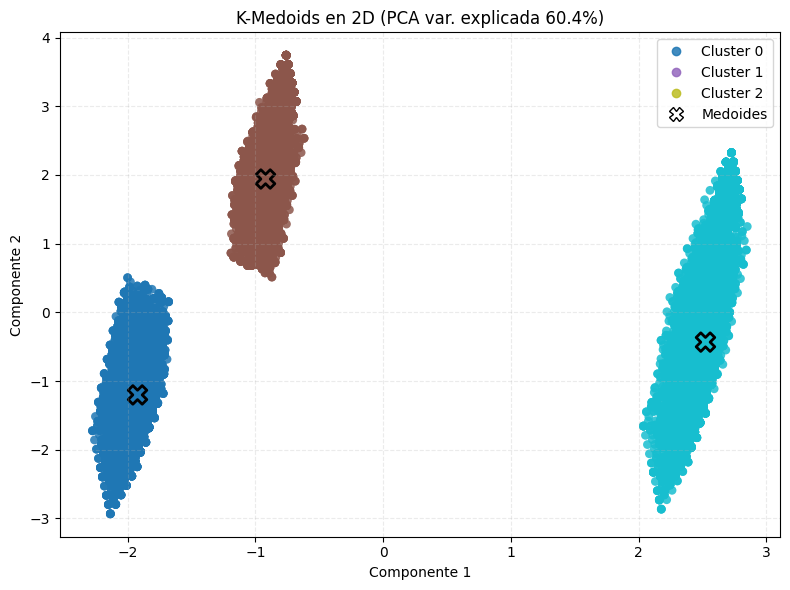

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Asumo que ya tienes X, kmed, labels
use_pca = X.shape[1] > 2
if use_pca:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(Xs)
    medoid_idx = kmed.get_medoids()
    medoids_2d = pca.transform(scaler.transform(X[medoid_idx]))
    title = f"K-Medoids en 2D (PCA var. explicada {pca.explained_variance_ratio_.sum():.1%})"
else:
    Z = X
    medoid_idx = kmed.get_medoids()
    medoids_2d = X[medoid_idx]
    title = "K-Medoids en 2D (features originales)"

plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", alpha=0.85, s=40, edgecolors="none")
plt.scatter(medoids_2d[:, 0], medoids_2d[:, 1],
            marker="X", s=180, linewidths=2,
            facecolors="none", edgecolors="black", label="Medoides")

# ← Aquí el fix
handles, _ = scatter.legend_elements(prop="colors", alpha=0.85,
                                     num=len(np.unique(labels)))
cluster_labels = [f"Cluster {i}" for i in np.unique(labels)]

plt.legend(handles + [plt.Line2D([0], [0], marker="X", linestyle="", markersize=10,
                                 markeredgecolor="black", markerfacecolor="none")],
           cluster_labels + ["Medoides"],
           loc="best", frameon=True)

plt.title(title)
plt.xlabel("Componente 1" if use_pca else "X1")
plt.ylabel("Componente 2" if use_pca else "X2")
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

# --- Asumo que ya tienes estos objetos de tu K-Medoids previo ---
# X = df_selected.drop(columns=["Anxiety Level"]).values
# kmed.process()
# labels = ...  (array de clusters)

# 1) PCA a 3D y proyección consistente para puntos y medoides
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(Xs)

medoid_idx = kmed.get_medoids()
medoids_3d = pca.transform(scaler.transform(X[medoid_idx]))

var_exp = pca.explained_variance_ratio_.sum()

# 2) DataFrame para Plotly
plot_df = pd.DataFrame(Z, columns=["Comp1", "Comp2", "Comp3"])
plot_df["Cluster"] = labels.astype(int).astype(str)
plot_df["Index"] = np.arange(len(plot_df))

# 3) Dispersión 3D por cluster
fig = px.scatter_3d(
    plot_df,
    x="Comp1", y="Comp2", z="Comp3",
    color="Cluster",
    hover_data=["Index"],
    opacity=0.9,
    title=f"K-Medoids en 3D • PCA var. explicada: {var_exp:.1%}"
)

# 4) Añadir medoides (símbolo X)
fig.add_trace(
    go.Scatter3d(
        x=medoids_3d[:, 0], y=medoids_3d[:, 1], z=medoids_3d[:, 2],
        mode="markers",
        name="Medoides",
        marker=dict(symbol="x", size=10, line=dict(width=3)),
        hovertemplate="Medoide<br>PC1=%{x:.3f}<br>PC2=%{y:.3f}<br>PC3=%{z:.3f}<extra></extra>"
    )
)

# 5) Estética
fig.update_layout(
    legend_title_text="Cluster",
    scene=dict(
        xaxis_title="Componente 1",
        yaxis_title="Componente 2",
        zaxis_title="Componente 3",
    ),
    template="plotly"
)

fig.show()

# 6) Guardar a HTML
#fig.write_html("kmedoids_3d.html", include_plotlyjs="cdn")



In [32]:
## Almacenado clusterización


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# --- 0) Datos: solo observables (sin 'Anxiety Level') ---
observables = df_selected.drop(columns=["Anxiety Level"]).to_numpy()

# --- 1) Escalado y proyección 1D (PC1) para seguir tu formato XP ---
scaler = StandardScaler()
X_std = scaler.fit_transform(observables)

pca = PCA(n_components=1)
XP = pca.fit_transform(X_std)          # shape: (n, 1)

# --- 2) K-Means sobre XP (1D) ---
k_optimo = 3   # cámbialo si quieres otro k
mkm = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)  # ¿Cuál es el mejor k? -> lo definiste antes
mkm.fit(XP)  # ya está (n,1), no hace falta reshape

# --- 3) Centros ordenados ---
XCp = mkm.cluster_centers_            # shape: (k, 1)
XCp = np.array(sorted(XCp.flatten())) # (k,) ordenados de menor→mayor
XCp = XCp.reshape(-1, 1)              # (k,1) para el broadcasting del loop

# --- 4) Clasificar por centro más cercano (vector cluster_var_no_obs) ---
cluster_var_obs = np.zeros((len(XP),), dtype=int)   # Vector de clusters

for k in range(len(XP)):
    dist = np.abs(XCp - XP[k, 0])       # distancia |centro - valor|
    cluster_var_obs[k] = np.argmin(dist)            # índice del cluster más cercano
    # print(k, XP[k, 0], cluster_var_no_obs[k])        # descomenta si quieres ver fila a fila

# --- 5) Guardar en el DataFrame si lo necesitas ---
df_selected["Cluster_Observables_Vector"] = cluster_var_obs

# (Opcional) revisar distribución
# print(np.bincount(cluster_var_no_obs))


In [37]:
df_selected.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week),Cluster_DBSCAN,Cluster_KMeans,PC1,PC2,PC3,Cluster_KMedoids,Cluster_Observables_Vector
0,False,0.888889,0.000000,0.25,0.4,0.6,0,2,0.943927,-0.706686,0.313347,1,1
1,False,0.111111,0.444444,0.50,0.4,0.8,0,2,-1.078901,-0.313229,-0.017221,0,2
2,True,1.000000,1.000000,0.00,1.0,0.0,1,1,0.579767,0.724292,0.125272,2,0
3,False,0.666667,0.888889,0.25,1.0,0.0,1,1,1.099165,-0.807206,-0.175825,1,1
4,False,1.000000,0.888889,1.00,1.0,0.6,1,1,0.926576,-0.770741,0.362680,1,1


In [34]:
### Generando matriz de emisión ---- Observables


import numpy as np

# Detectar cuántos estados/clusters hay
k_hidden = len(np.unique(cluster_var_no_obs))   # Anxiety Level (no observable)
k_obs    = len(np.unique(cluster_var_obs))      # Observables  cluster_var_no_obs

# Matriz de conteos (filas: observables, columnas: no-observables)
MEp = np.zeros((k_obs, k_hidden), dtype=int)

# Llenar conteos
# IMPORTANTE: asumir que los vectores están alineados por índice temporal (t)
for k in range(len(cluster_var_obs) - 1):
    nc = int(cluster_var_no_obs[k])  # "no observable" (hidden)
    nf = int(cluster_var_obs[k])     # "observable"
    MEp[nf, nc] += 1

print("Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:\n", MEp)

# Probabilidades por fila -> P(hidden | observed)
row_sums = MEp.sum(axis=1, keepdims=True)
MEPp = np.divide(MEp, row_sums, where=row_sums != 0)

print("Matriz de Emisión (probabilidades) P(hidden | observed):\n", MEPp)


NameError: name 'cluster_var_no_obs' is not defined

In [ ]:
MEp  # matriz de conteos
MEPp = MEp / np.sum(MEp, axis=1, keepdims=True)   # Probabilidades


NameError: name 'MEp' is not defined

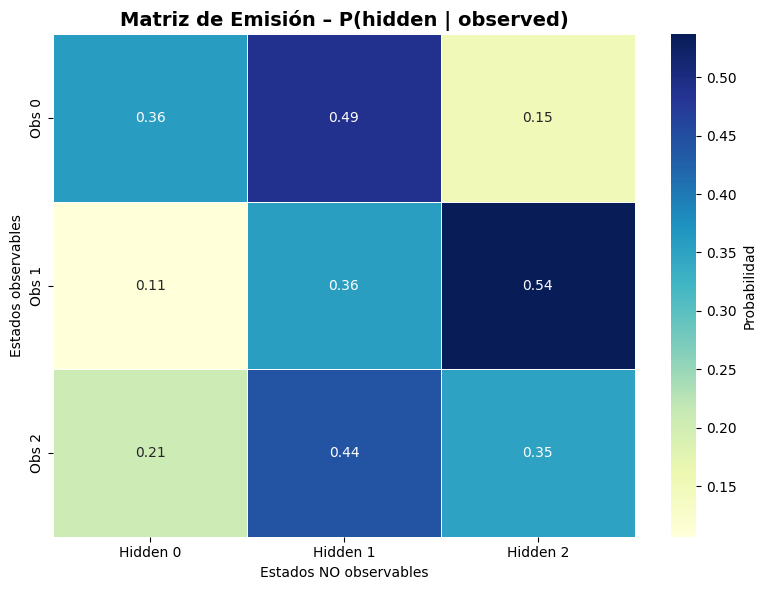

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Etiquetas
k_hidden = len(np.unique(cluster_var_no_obs))  # No observable
k_obs    = len(np.unique(cluster_var_obs))     # Observable

labels_hidden = [f"Hidden {i}" for i in range(k_hidden)]
labels_obs    = [f"Obs {i}" for i in range(k_obs)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MEPp,
    annot=True, fmt=".2f", cmap="YlGnBu",
    linewidths=0.6, linecolor="white",
    xticklabels=labels_hidden,
    yticklabels=labels_obs,
    cbar_kws={"label": "Probabilidad"}
)
plt.title("Matriz de Emisión – P(hidden | observed)", fontsize=14, weight="bold")
plt.xlabel("Estados NO observables")
plt.ylabel("Estados observables")
plt.tight_layout()
plt.show()


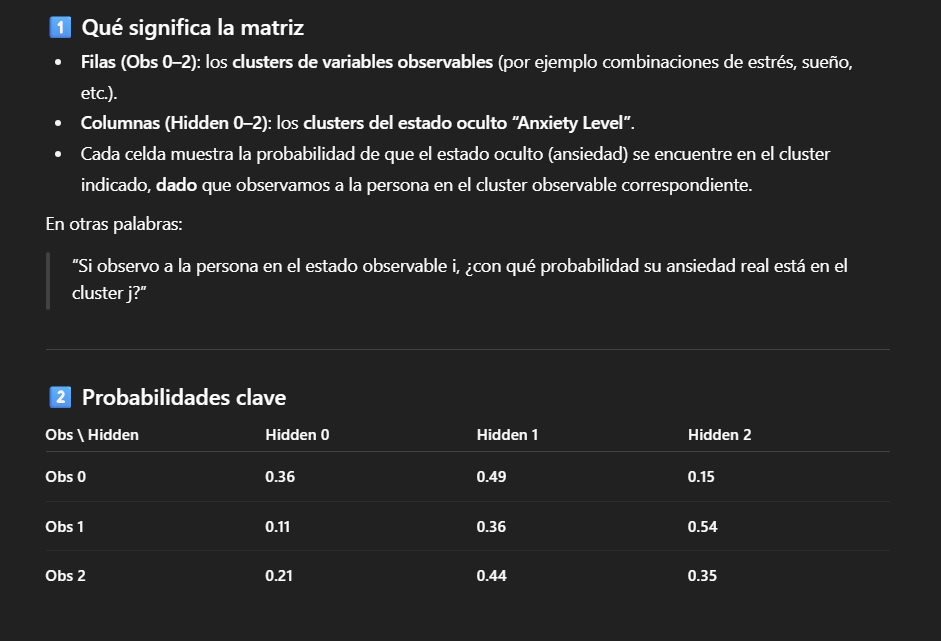

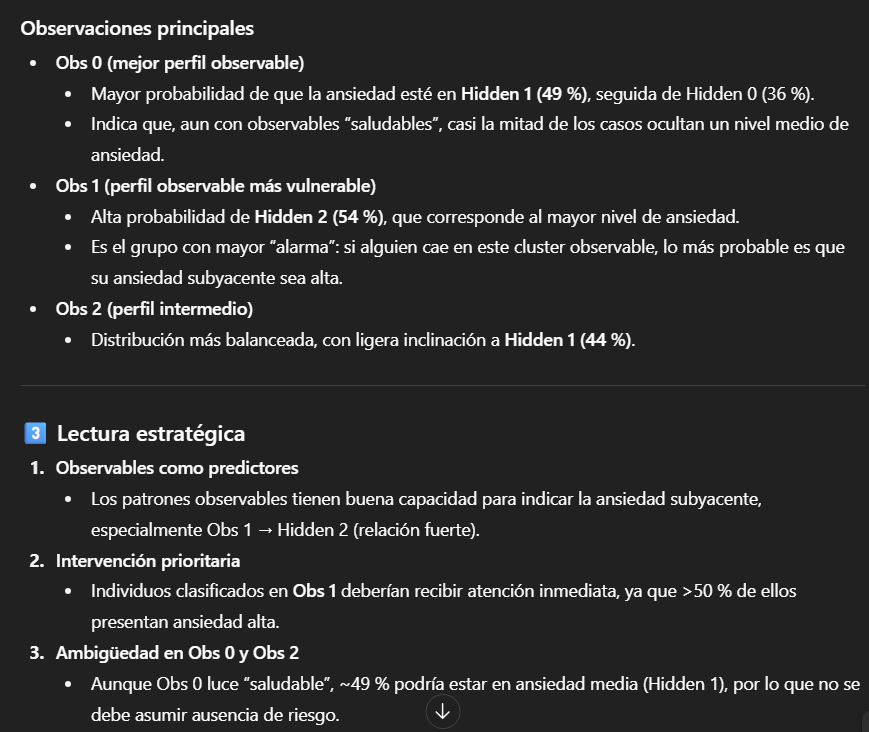

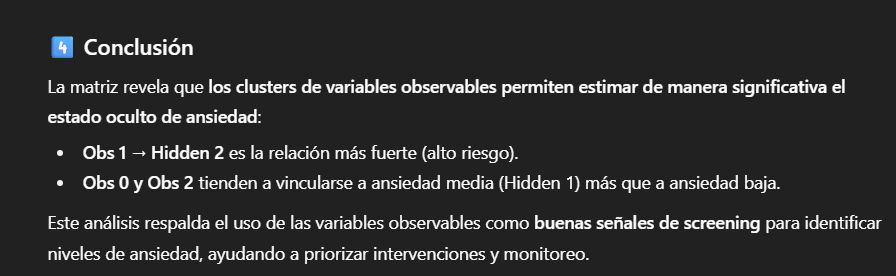

## Modelación - Variables no observables

In [27]:
cols = [
    'Anxiety Level'
]

# Filtra solo las columnas que existen en df_XDB_ID
cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_anx  = df_XDB_ID[cols_exist].copy()


In [28]:
df_anx.head()

,Anxiety Level
0,0.4
1,0.4
2,1.0
3,1.0
4,1.0


In [29]:


# --- 0) Datos ---
# df_anx: DataFrame con columna 'Anxiety Level'
assert 'Anxiety Level' in df_anx.columns, "Debe existir la columna 'Anxiety Level'"

# 1.Limpieza mínima
s = pd.to_numeric(df_anx['Anxiety Level'], errors='coerce').dropna()
X = s.values.reshape(-1, 1)

# --- 2) DBSCAN en 1D ---
# Ajusta eps/min_samples según densidad de tus datos:
dbscan = DBSCAN(eps=0.5, min_samples=5)   # prueba eps in [0.2..1.0] y min_samples [3..10]
labels = dbscan.fit_predict(X)      # -1 = ruido

# Guardar resultados
df_plot = s.to_frame(name='Anxiety Level').reset_index(drop=False).rename(columns={'index':'idx'})
df_plot['Cluster'] = labels

# --- 3) Colores: ruido en gris ---
palette = px.colors.qualitative.T10 + px.colors.qualitative.Set3 + px.colors.qualitative.Safe
uniq = sorted(df_plot['Cluster'].unique())
color_discrete_map = {}
pi = 0
for u in uniq:
    if u == -1:
        color_discrete_map[u] = "gray"
    else:
        color_discrete_map[u] = palette[pi % len(palette)]
        pi += 1

# --- 4) PLOTLY 2D (valor vs jitter) ---
rng = np.random.default_rng(42)
df_plot['jitter'] = rng.normal(loc=0.0, scale=0.02, size=len(df_plot))  # solo visual
fig2d = px.scatter(
    df_plot,
    x='Anxiety Level', y='jitter',
    color='Cluster',
    color_discrete_map=color_discrete_map,
    opacity=0.9,
    hover_data={'idx': True, 'Anxiety Level': ':.4f', 'jitter': False, 'Cluster': True},
    title="DBSCAN en 1D (Anxiety Level) — Vista 2D con jitter"
)
fig2d.update_traces(marker=dict(size=6, line=dict(width=0.5, color="black")))
fig2d.update_yaxes(visible=False, showticklabels=False)
fig2d.update_layout(legend_title_text="Etiqueta DBSCAN")
fig2d.show()
# fig2d.write_html("dbscan_anxiety_2d.html", include_plotlyjs="cdn")  # opcional

# --- 5) PLOTLY 3D (visualización enriquecida) ---
# NOTA: DBSCAN se hizo en 1D; estas 3 dimensiones son SOLO para visualizar.
df_plot['Rank'] = s.rank(pct=True).values                 # percentil [0,1]
df_plot['MA_5'] = s.rolling(window=5, min_periods=1).mean().values  # media móvil simple

fig3d = px.scatter_3d(
    df_plot,
    x='Anxiety Level', y='Rank', z='MA_5',
    color='Cluster',
    color_discrete_map=color_discrete_map,
    opacity=0.9,
    hover_data={'idx': True, 'Anxiety Level': ':.4f', 'Rank': ':.3f', 'MA_5': ':.4f'},
    title="DBSCAN en 1D (Anxiety Level) — Vista 3D (Valor, Percentil, Media móvil)"
)
fig3d.update_traces(marker=dict(size=4, line=dict(width=0.5, color="black")))
fig3d.update_layout(
    legend_title_text="Etiqueta DBSCAN",
    scene=dict(
        xaxis_title="Anxiety Level",
        yaxis_title="Percentil (rank)",
        zaxis_title="Media móvil (5)"
    )
)
fig3d.show()
# fig3d.write_html("dbscan_anxiety_3d.html", include_plotlyjs="cdn")  # opcional

# --- 6) (Opcional) Vector de niveles 0..K-1 ordenados por centro del valor (sin contar ruido) ---
#labels_arr = df_plot['Cluster'].to_numpy()
#valid = labels_arr != -1
#clusters_validos = np.unique(labels_arr[valid])

#niveles = np.full_like(labels_arr, fill_value=-1, dtype=int)
#if len(clusters_validos) > 0:
    # centro (mediana) de cada cluster en el valor original
    #centros = df_plot[valid].groupby('Cluster')['Anxiety Level'].median().sort_values()
    #mapping = {cl: i for i, cl in enumerate(centros.index)}  # menor valor -> nivel 0
    #niveles[valid] = np.vectorize(mapping.get)(labels_arr[valid])

#df_plot['Nivel_DBSCAN'] = niveles
# Si quieres reasignar el ruido al nivel más cercano por valor:
# for i in np.where(df_plot['Nivel_DBSCAN'] == -1)[0]:
#     val = df_plot.loc[i, 'Anxiety Level']
#     dif = np.abs(centros.values - val)
#     df_plot.loc[i, 'Nivel_DBSCAN'] = int(np.argmin(dif))

# Resultado final:
# - df_plot: contiene 'Anxiety Level', 'Cluster', 'Nivel_DBSCAN' y se usó para las gráficas.


e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.



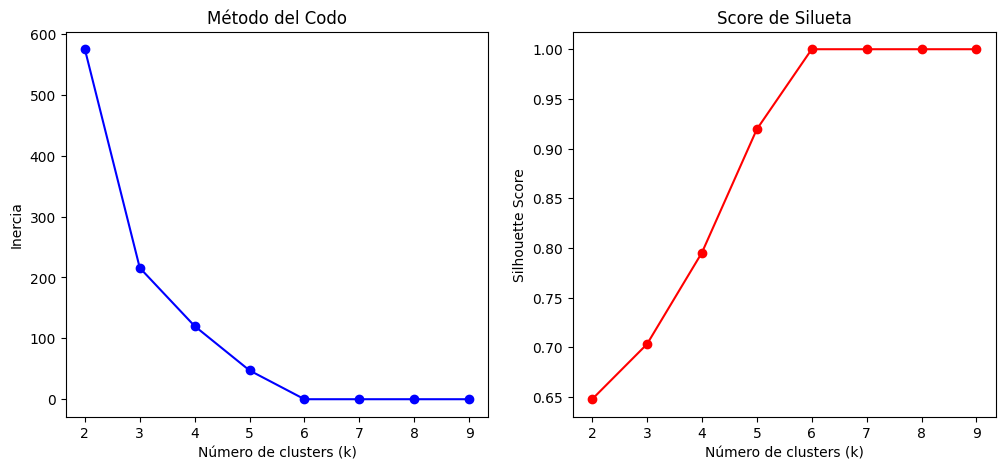

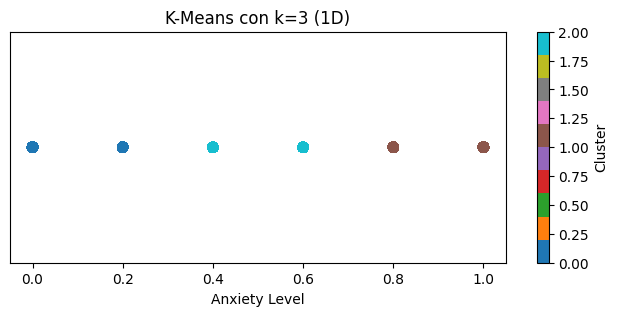

Cluster_KMeans
2    9568
1    7307
0    5125
Name: count, dtype: int64
                Anxiety Level
Cluster_KMeans               
0                    0.128000
1                    0.905707
2                    0.502069


In [30]:
### K-Means
# --- 0) Datos ---




# 1. Cargar dataset
# 2. Seleccionar variables no_observables
no_observables = df_anx

# 3. Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  # probar entre 2 y 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(no_observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(no_observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# 4. Ajustar modelo con el k óptimo (ejemplo k=3)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(no_observables)

# 5. Visualización en 1D (solo hay una variable)
plt.figure(figsize=(8, 3))
plt.scatter(no_observables.values.flatten(), np.zeros_like(no_observables.values), 
            c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (1D)")
plt.xlabel("Anxiety Level")
plt.yticks([])
plt.colorbar(label="Cluster")
plt.show()

# 6. Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[no_observables.columns].mean())


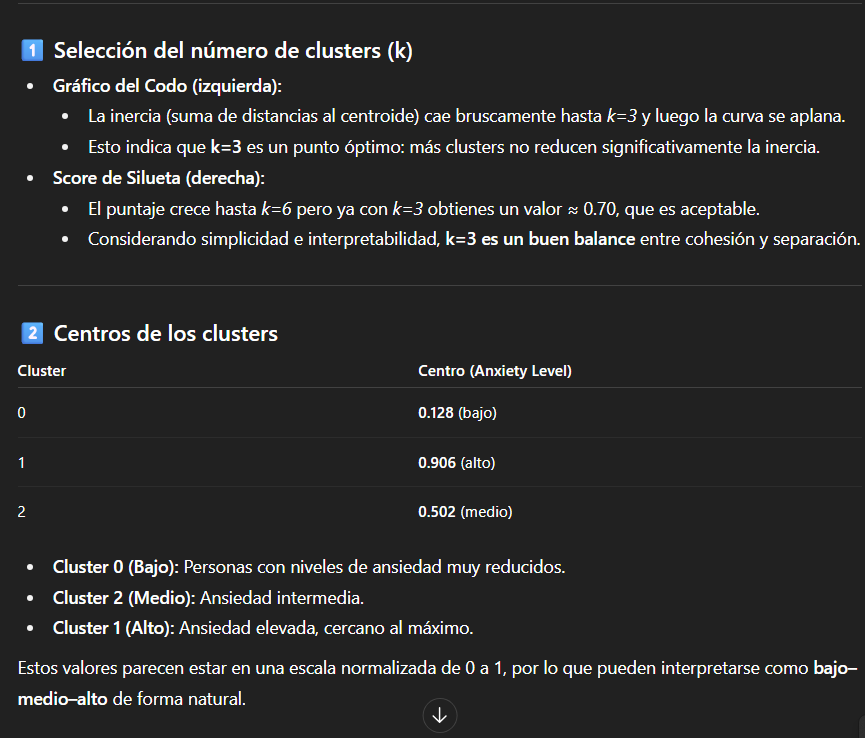

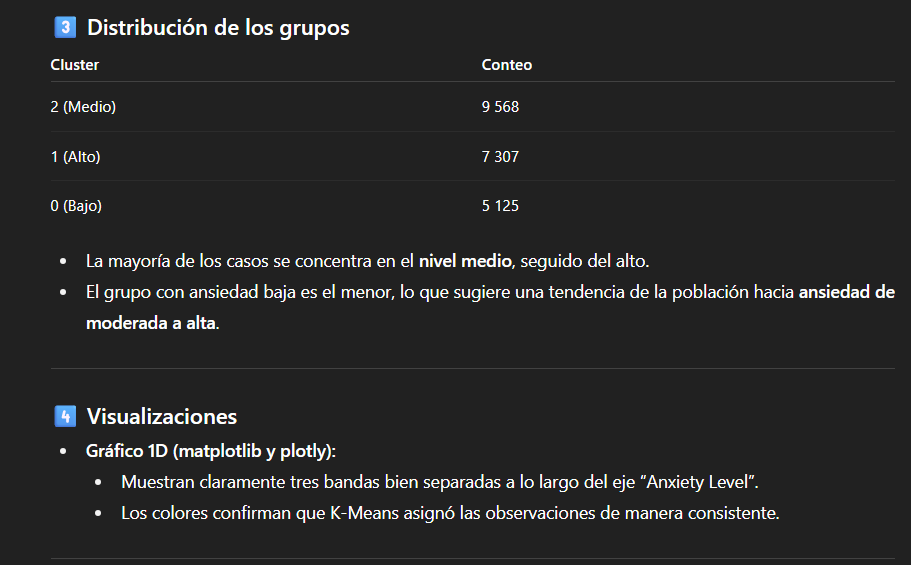

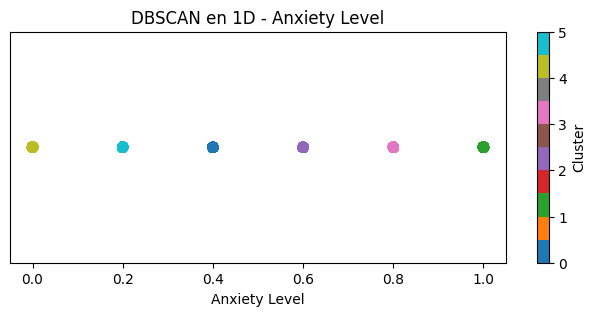

Conteo por cluster:
Cluster_DBSCAN
2    4883
0    4685
1    3862
3    3445
5    3280
4    1845
Name: count, dtype: int64

Promedios por cluster:
                Anxiety Level
Cluster_DBSCAN               
0                         0.4
1                         1.0
2                         0.6
3                         0.8
4                         0.0
5                         0.2


In [31]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Datos ---
# Supongo que df_anx es un DataFrame con la columna 'Anxiety Level'
no_observables = df_anx  # misma variable que usaste

# --- 1) Escalar los datos ---
# DBSCAN es sensible a la escala, por eso normalizamos
X_scaled = StandardScaler().fit_transform(no_observables)

# --- 2) Ajustar DBSCAN ---
# Ajusta eps y min_samples según tu dataset
dbscan = DBSCAN(eps=0.5, min_samples=10)   # prueba inicial
labels = dbscan.fit_predict(X_scaled)

# Guardar en el dataframe original
df_selected["Cluster_DBSCAN"] = labels

# --- 3) Visualización 1D ---
plt.figure(figsize=(8, 3))
# flatten() para obtener vector 1D, np.zeros_like para ubicar en el eje y=0
plt.scatter(no_observables.values.flatten(),
            np.zeros_like(no_observables.values),
            c=labels, cmap="tab10", s=50)

plt.title("DBSCAN en 1D - Anxiety Level")
plt.xlabel("Anxiety Level")
plt.yticks([])
plt.colorbar(label="Cluster")
plt.show()

# --- 4) Resumen de resultados ---
# DBSCAN puede generar el cluster -1 para puntos marcados como ruido
print("Conteo por cluster:")
print(df_selected["Cluster_DBSCAN"].value_counts())

print("\nPromedios por cluster:")
print(df_selected.groupby("Cluster_DBSCAN")[no_observables.columns].mean())


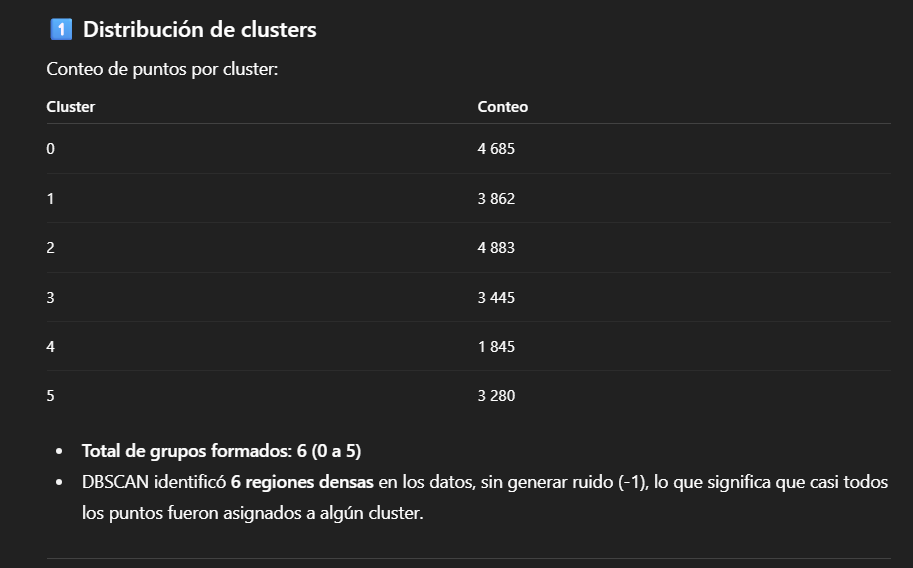

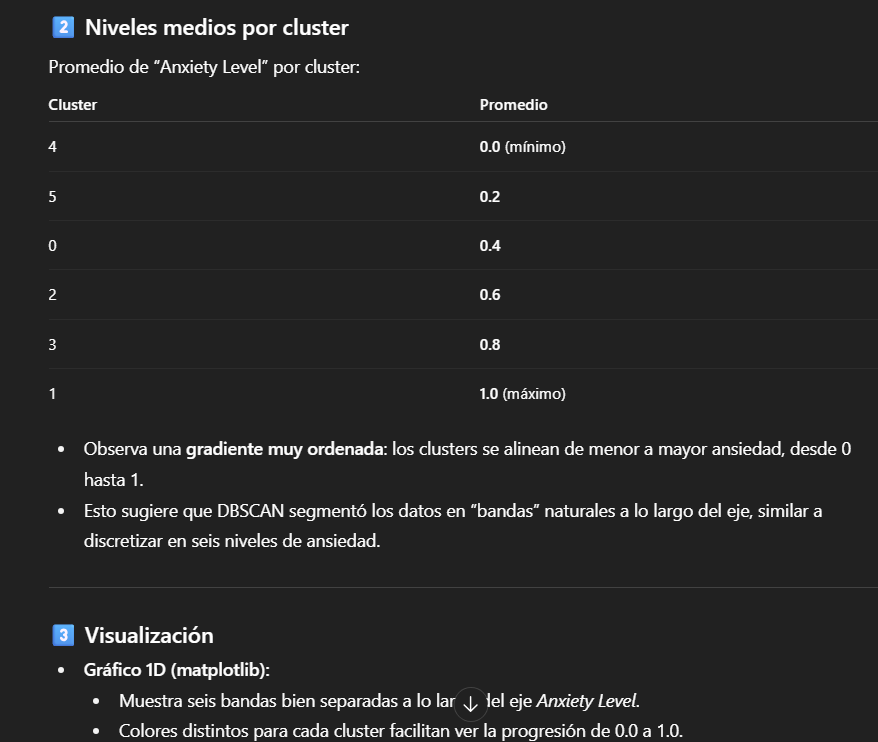

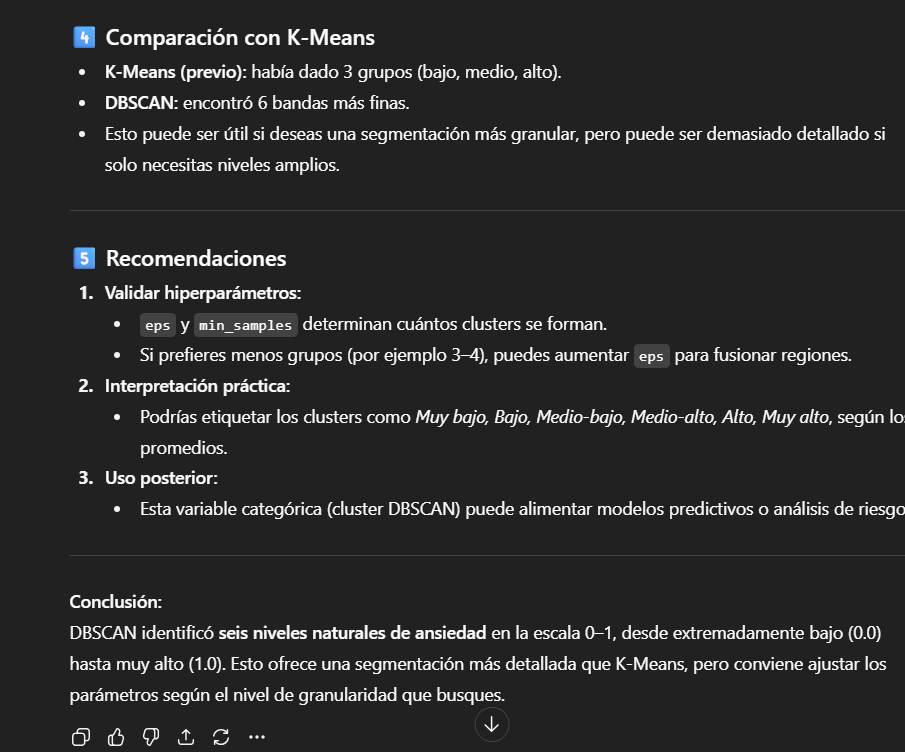

In [ ]:
###  Almacenando clusterizacion 



from sklearn.cluster import KMeans
from scipy.stats import skew


# --- 1) Ajustar modelo K-Means ---
# Supongamos que df_anx es tu DataFrame con la variable 'Anxiety Level'
y_cont = df_anx.values.reshape(-1, 1)

mkm = KMeans(n_clusters=3, random_state=42, n_init=10)  # k=3 según tu análisis
mkm.fit(y_cont)

# --- 2) Centros ordenados ---
XCo = mkm.cluster_centers_
XCo = np.array(sorted(XCo.flatten()))   # ordena de menor a mayor

print("Coeficiente de asimetría de Anxiety Level:", skew(y_cont))
print("Centros de los clusters:\n", XCo)

# --- 3) Clasificación de cada dato en un vector ---
cluster_var_no_obs = np.zeros(len(y_cont), dtype=int)   # vector para guardar cluster de cada punto

for k in range(len(y_cont)):
    # distancia de este dato a cada centro
    dist = np.abs(XCo - y_cont[k, 0])
    # índice del centro más cercano
    cluster_var_no_obs[k] = np.argmin(dist)

# --- 4) Resultado ---
print("Vector de clusters (primeros 20 valores):", cluster_var_no_obs[:20])


Coeficiente de asimetría de Anxiety Level: [-0.07965955]
Centros de los clusters:
 [0.128      0.5020694  0.90570686]
Vector de clusters (primeros 20 valores): [1 1 2 2 2 1 2 0 0 0 1 1 0 2 0 1 2 0 1 1]


In [35]:
## Generando matriz de transicion

# Supongamos que:
# cluster_var_no_obs es un vector 1D de enteros (0..k-1)
# y_cont es el array con la variable Anxiety Level

k_clusters = len(np.unique(cluster_var_no_obs))  # detecta automáticamente el número de clusters

# --- 1) Matriz de transición en conteos ---
MTr = np.zeros((k_clusters, k_clusters), dtype=int)

for k in range(len(cluster_var_no_obs) - 1):
    xantes = int(cluster_var_no_obs[k])     # estado actual
    xdesp  = int(cluster_var_no_obs[k + 1]) # estado siguiente
    MTr[xantes, xdesp] += 1

print("Matriz de Transición (conteos):\n", MTr)

# --- 2) Matriz de transición en probabilidades ---
# Sumar por filas y evitar división por cero
row_sums = MTr.sum(axis=1, keepdims=True)
MTrp = np.divide(MTr, row_sums, where=row_sums!=0)

print("Matriz de Transición (probabilidades):\n", MTrp)


NameError: name 'cluster_var_no_obs' is not defined

In [36]:

# Supongamos que MTrp es tu matriz de transición de probabilidades
# y cluster_var_no_obs es tu vector de clusters

k_clusters = len(np.unique(cluster_var_no_obs))
labels = [f"Cluster {i}" for i in range(k_clusters)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MTrp,
    annot=True,           # muestra los valores dentro de las celdas
    fmt=".2f",            # formato con 2 decimales
    cmap="YlGnBu",        # paleta de colores (puedes probar 'coolwarm', 'viridis', etc.)
    cbar_kws={"label": "Probabilidad de Transición"},
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,       # separadores entre celdas
    linecolor='white'
)

plt.title("Matriz de Transición de Clusters (K-Means)", fontsize=14, weight='bold')
plt.xlabel("Estado Siguiente", fontsize=12)
plt.ylabel("Estado Actual", fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'cluster_var_no_obs' is not defined

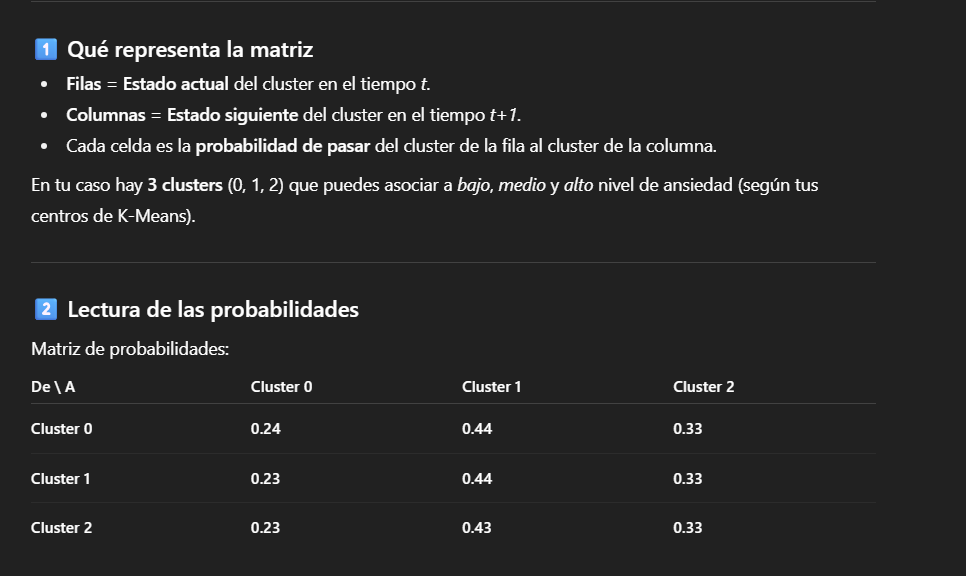

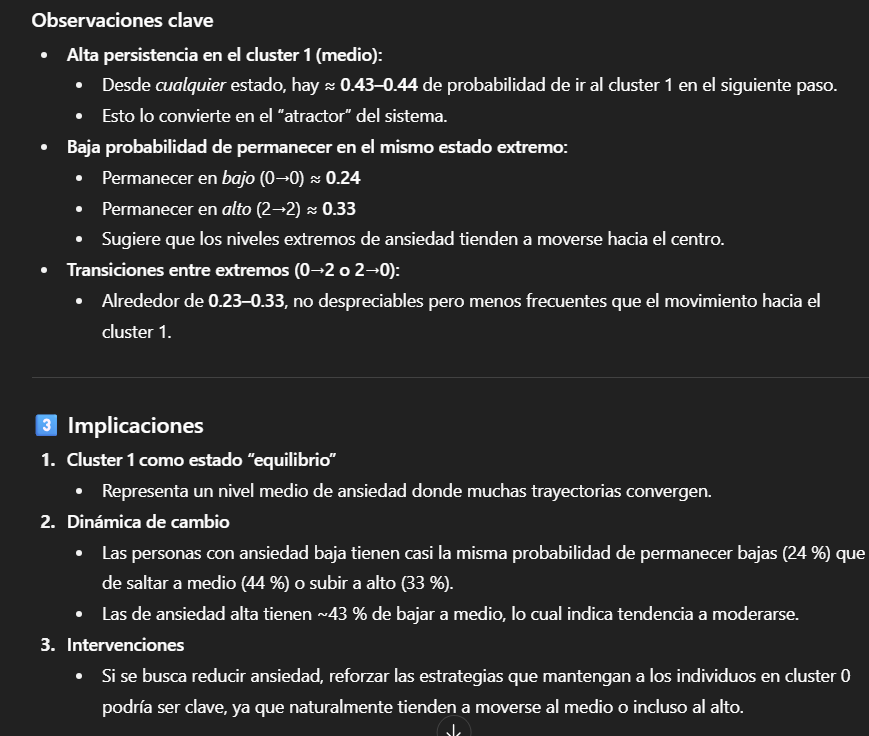

## Modelación del vector de distribución de estados (pi)

In [ ]:
VRo=np.sum(MTr,axis=1)   #Este vector tiene que ser sobre los datos de construcción del modelo
VRop=VRo/np.sum(VRo)
print("La estructura porcentual del riesgo es:",VRop)

La estructura porcentual del riesgo es: [0.23296513 0.43492886 0.332106  ]


Estructura porcentual del riesgo (vector inicial): [0.23296513 0.43492886 0.332106  ]


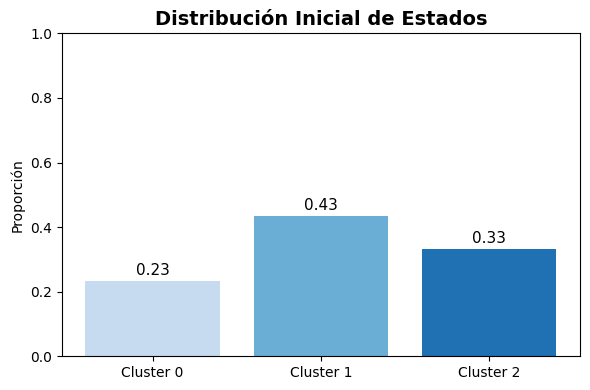

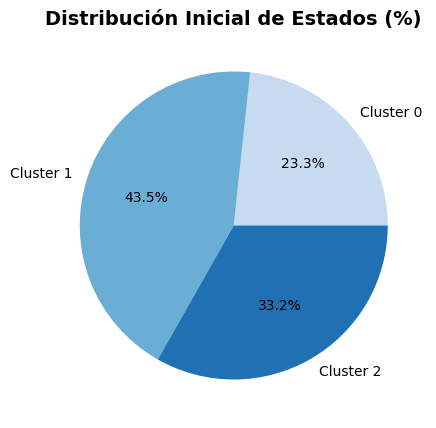

In [ ]:

# --- 1) Vector inicial a partir de la matriz de transición ---
# MTr es tu matriz de transición (conteos)
VRo = np.sum(MTr, axis=1)          # suma por filas: total de salidas de cada estado
VRop = VRo / np.sum(VRo)           # distribución porcentual
print("Estructura porcentual del riesgo (vector inicial):", VRop)

# --- 2) Gráfico de barras simple (matplotlib) ---
estados = [f"Cluster {i}" for i in range(len(VRop))]

plt.figure(figsize=(6,4))
bars = plt.bar(estados, VRop, color=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0, 1)

# Mostrar valores encima de cada barra
for bar, p in zip(bars, VRop):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{p:.2f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# --- 3) (Opcional) Gráfico tipo pastel ---
plt.figure(figsize=(5,5))
plt.pie(VRop, labels=estados, autopct="%1.1f%%",
        colors=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados (%)", fontsize=14, weight="bold")
plt.show()


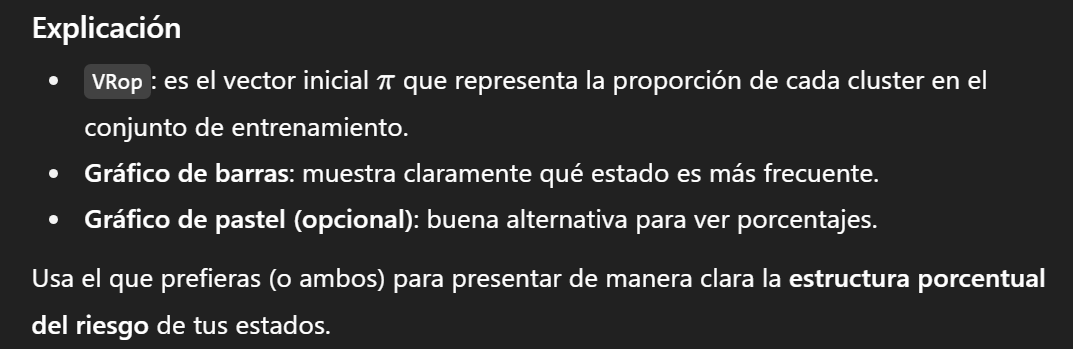

## Modelacion Forward-backward 

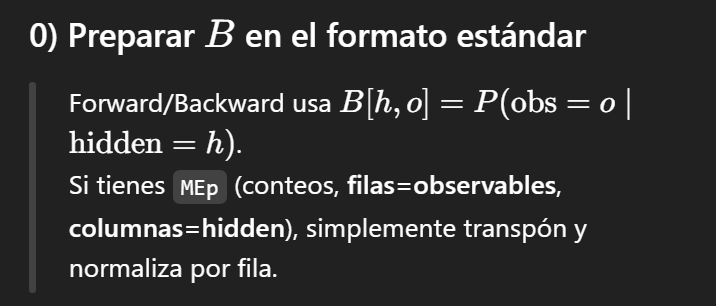

In [ ]:

# A: MTrp (N x N)
A = MTrp.copy().astype(float)

# pi: VRop (N,)
pi = VRop.copy().astype(float)  # debe sumar 1

# Secuencia de observaciones (enteros 0..M-1) — tus clusters observables
obs_seq = np.asarray(cluster_var_obs, dtype=int)

# --- Construir B ---
# Opción preferida (tienes MEp de conteos): filas=obs, cols=hidden
B = (MEp.T).astype(float)                         # (N x M) = (hidden x observed)
B = B / B.sum(axis=1, keepdims=True)             # normaliza por fila -> P(obs|hidden)




### Algoritmo Forward

In [ ]:
def forward_backward(obs_seq, A, B, pi):
    """
    obs_seq: array de enteros (T,)
    A: (N, N)  transición
    B: (N, M)  emisión  P(obs|hidden)
    pi: (N,)   inicial
    """
    import numpy as np

    obs_seq = np.asarray(obs_seq, dtype=int)
    N = A.shape[0]
    T = len(obs_seq)

    alpha = np.zeros((T, N), dtype=float)
    beta  = np.zeros((T, N), dtype=float)
    c     = np.zeros(T, dtype=float)  # factores de escalado

    # --- Forward inicial ---
    alpha[0] = pi * B[:, obs_seq[0]]
    c[0] = alpha[0].sum()
    alpha[0] /= max(c[0], 1e-12)

    # --- Forward recursivo ---
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs_seq[t]]
        c[t] = alpha[t].sum()
        alpha[t] /= max(c[t], 1e-12)

    # --- Log-likelihood ---
    loglik = np.sum(np.log(np.maximum(c, 1e-12)))

    # --- Backward inicial (escalado) ---
    beta[-1] = 1.0 / max(c[-1], 1e-12)

    # --- Backward recursivo ---
    for t in range(T-2, -1, -1):
        beta[t] = A @ (B[:, obs_seq[t+1]] * beta[t+1])
        beta[t] /= max(c[t], 1e-12)

    # --- Posterior por estado ---
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)

    # --- Posterior por par (xi) ---
    xi = np.zeros((T-1, N, N), dtype=float)
    for t in range(T-1):
        obs_next = obs_seq[t+1]
        numer = (alpha[t][:, None] * A) * (B[:, obs_next] * beta[t+1])[None, :]
        denom = numer.sum()
        if denom > 0:
            xi[t] = numer / denom

    return alpha, beta, gamma, xi, loglik


In [ ]:


A  = MTrp.astype(float)          # (N, N)
pi = VRop.astype(float)          # (N,)
obs_seq = np.asarray(cluster_var_obs, dtype=int)   # (T,)


In [ ]:
alpha, beta, gamma, xi, loglik = forward_backward(obs_seq, A, B, pi)

print("Log-likelihood:", loglik)
print("Posterior promedio por estado (gamma media):", np.round(gamma.mean(axis=0), 3))

# Decodificación “suave” (estado más probable en cada t):
path_soft = gamma.argmax(axis=1)
print("Trayectoria (soft) primeros 20:", path_soft[:20])


Log-likelihood: -24019.000224625743
Posterior promedio por estado (gamma media): [0.233 0.435 0.332]
Trayectoria (soft) primeros 20: [2 1 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1]


In [ ]:
##Checks rapidos


# Cada fila de gamma debe sumar 1
assert np.allclose(gamma.sum(axis=1), 1.0, atol=1e-6)

# A y B están bien normalizadas
assert np.allclose(A.sum(axis=1), 1.0, atol=1e-6)
assert np.allclose(B.sum(axis=1), 1.0, atol=1e-6)
assert np.isclose(pi.sum(), 1.0, atol=1e-6)


In [ ]:
# Conteos esperados de transiciones y re-normalización a matriz
A_expected = xi.sum(axis=0)           # (N, N)
A_expected = A_expected / np.maximum(A_expected.sum(axis=1, keepdims=True), 1e-12)

print("A esperada (de xi):\n", np.round(A_expected, 3))


A esperada (de xi):
 [[0.236 0.435 0.329]
 [0.232 0.435 0.333]
 [0.233 0.434 0.333]]


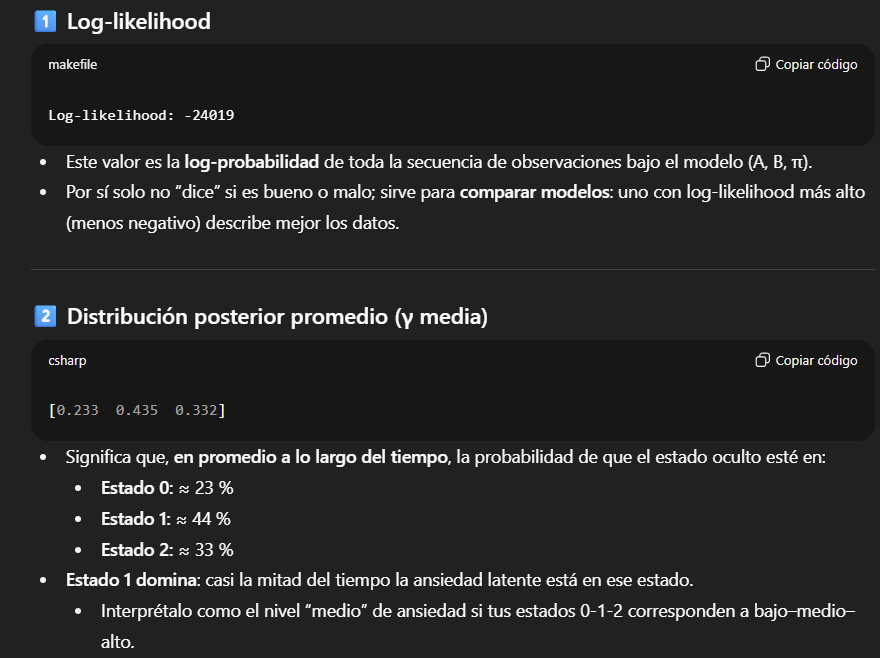

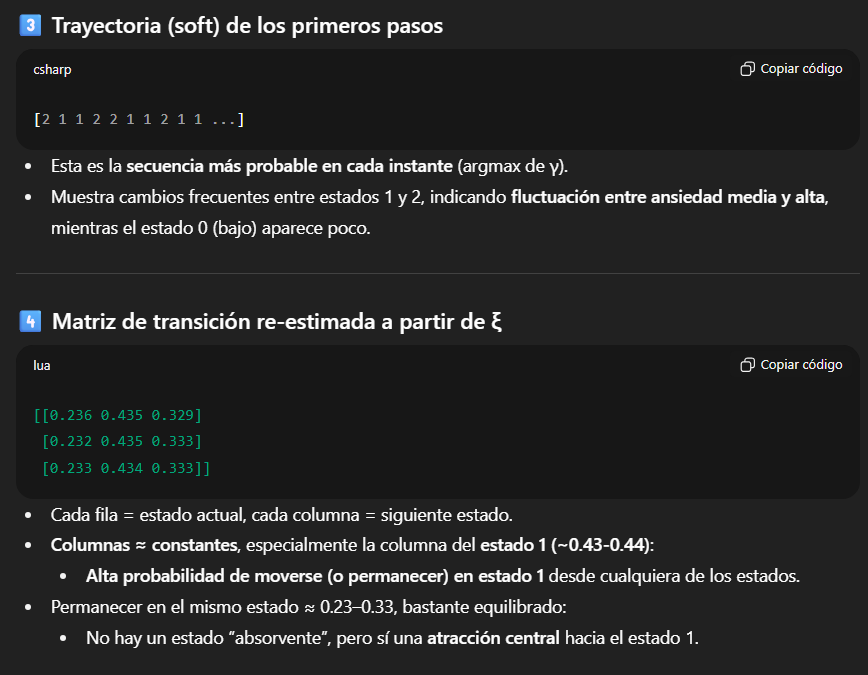

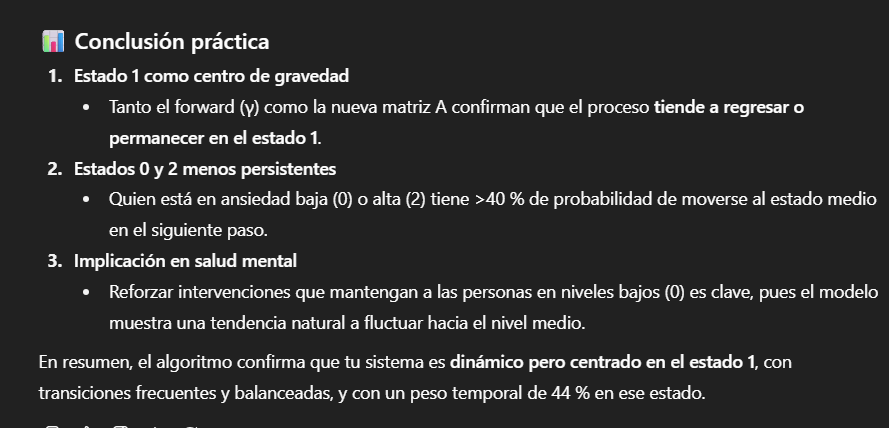

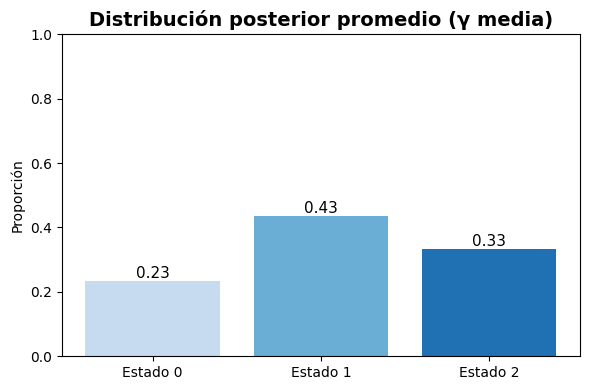

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

gamma_mean = np.array([0.233, 0.435, 0.332])   # tu gamma media
states = [f"Estado {i}" for i in range(len(gamma_mean))]

plt.figure(figsize=(6,4))
bars = plt.bar(states, gamma_mean, color=sns.color_palette("Blues", len(states)))
plt.title("Distribución posterior promedio (γ media)", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0,1)
for b,p in zip(bars, gamma_mean):
    plt.text(b.get_x()+b.get_width()/2, p+0.01, f"{p:.2f}", ha="center", fontsize=11)
plt.tight_layout()
plt.show()


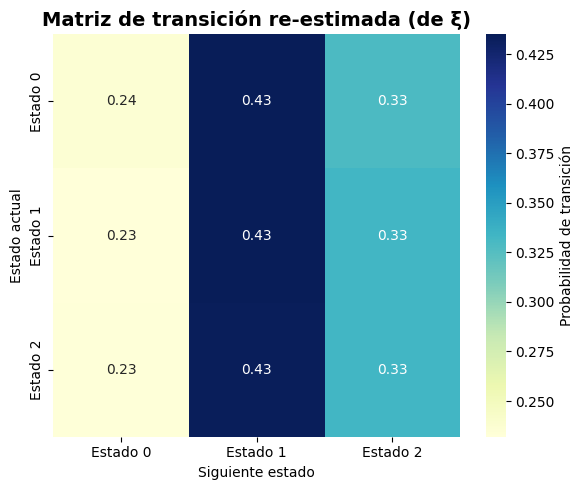

In [ ]:
A_expected = np.array([
    [0.236, 0.435, 0.329],
    [0.232, 0.435, 0.333],
    [0.233, 0.434, 0.333]
])

plt.figure(figsize=(6,5))
sns.heatmap(A_expected, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=states, yticklabels=states,
            cbar_kws={"label": "Probabilidad de transición"})
plt.title("Matriz de transición re-estimada (de ξ)", fontsize=14, weight="bold")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.tight_layout()
plt.show()


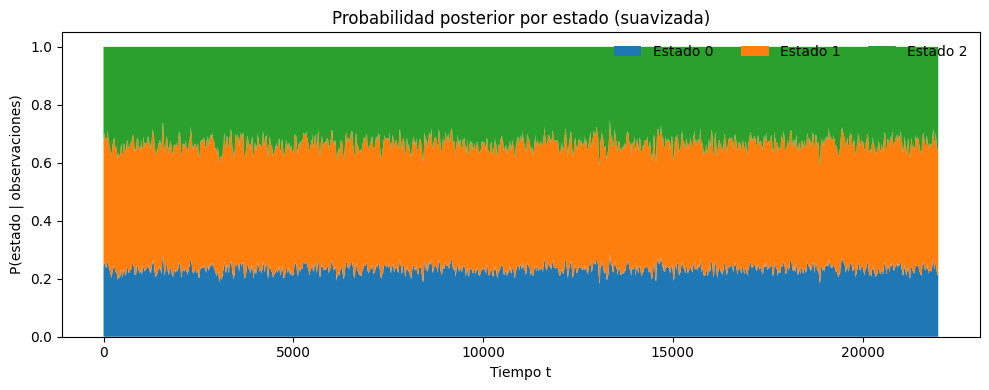

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# gamma: matriz (T, N)
T, N = gamma.shape
t = np.arange(T)

# --- suavizado: media móvil ---
win = max(25, T // 500)          # ventana adaptativa
g_smooth = pd.DataFrame(gamma).rolling(win, center=True, min_periods=1).mean().to_numpy()

# --- downsampling para aligerar el dibujo ---
step = max(1, T // 1500)         # ~1500 puntos como máx.
t_ds = t[::step]
g_ds = g_smooth[::step].T        # shape (N, T_ds) para stackplot

plt.figure(figsize=(10,4))
plt.stackplot(t_ds, *g_ds, labels=[f"Estado {i}" for i in range(N)])
plt.title("Probabilidad posterior por estado (suavizada)")
plt.xlabel("Tiempo t")
plt.ylabel("P(estado | observaciones)")
plt.legend(loc="upper right", ncols=min(N,3), frameon=False)
plt.tight_layout()
plt.show()


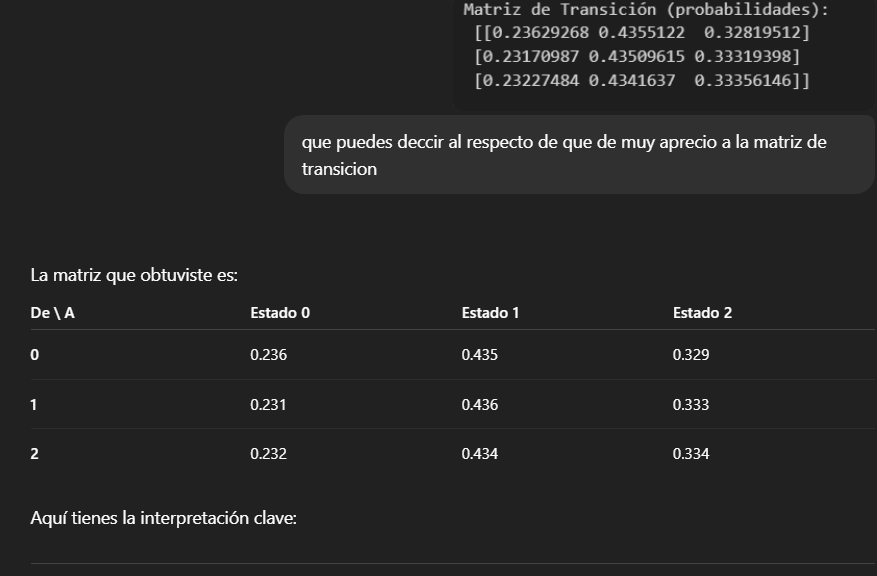

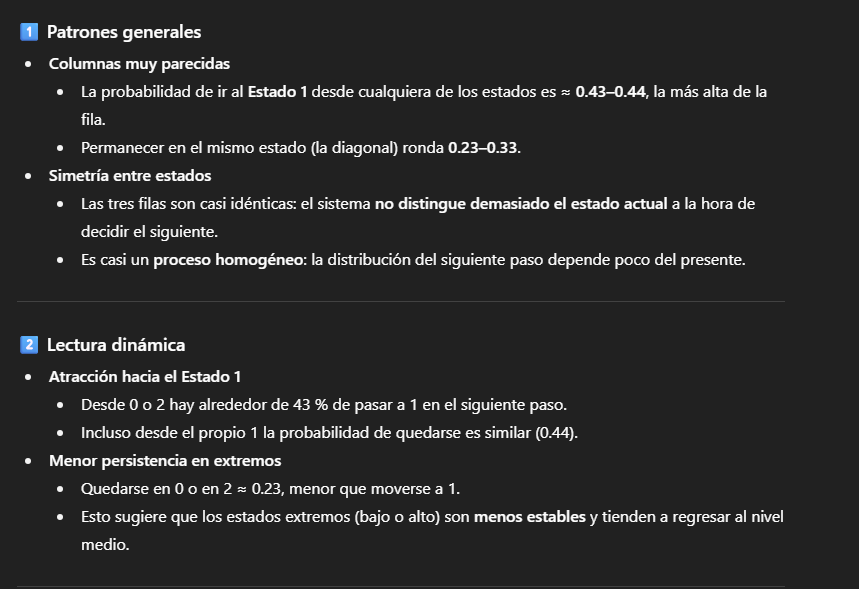

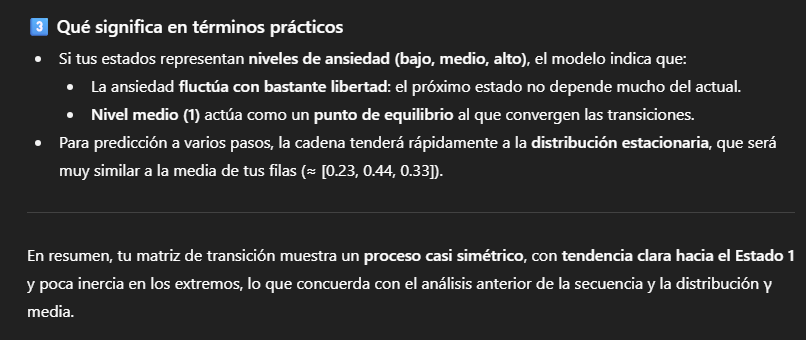